# Face RecognitionThe aim of this notebook is to recognize faces using computer vision techniques. We will explore the CascadeClassifier feature extraction method and model architectures to achieve this goal. Face recognition enhances security systems by providing accurate and efficient identification of individuals, plays a crucial role in law enforcement for identifying suspects and missing persons, and improves customer verification processes in the financial sector. By advancing face recognition technology, we contribute to making processes more secure, efficient, and user-friendly across different domains, demonstrating its broad impact and potential benefits in everyday life..
.
.


In [1]:
import os
import cv2
import pywt
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#### 1. Preprocessing: Detect face and eyes
When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.
\
The haar cascade from OpenCV is used for this purpose.

In [2]:
img = cv2.imread("./test_images/Maryam-Mirzakhani-1.jpg")
img.shape

(1024, 724, 3)

(-0.5, 723.5, 1023.5, -0.5)

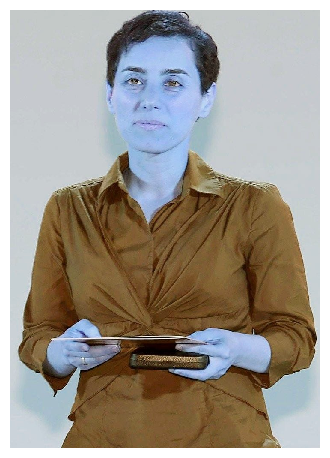

In [3]:
plt.matshow(img)
plt.axis('off')

In [4]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_img.shape

(1024, 724)

In [5]:
gray_img

array([[200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200],
       ...,
       [212, 212, 212, ..., 211, 211, 211],
       [213, 213, 212, ..., 212, 212, 212],
       [213, 213, 212, ..., 213, 213, 213]], dtype=uint8)

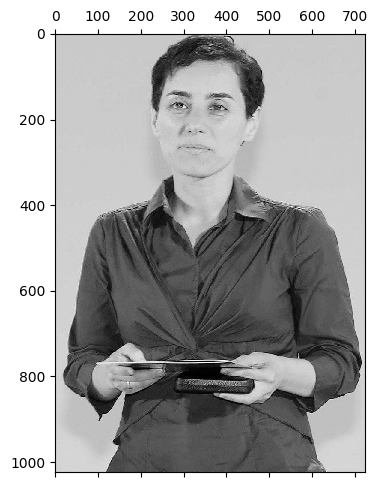

In [6]:
plt.matshow(gray_img, cmap = 'gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
faces

array([[194,  60, 279, 279]])

In [8]:
(x , y , w , h) = faces[0]
x , y , w , h

(194, 60, 279, 279)

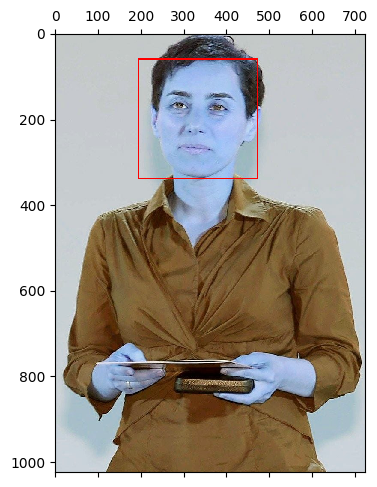

In [9]:
face_img = cv2.rectangle(img, (x , y), (x+w , y+h), (255 , 0 , 0), 2)
plt.matshow(face_img)

#### 2. Preprocessing: Crop the facial region of the image

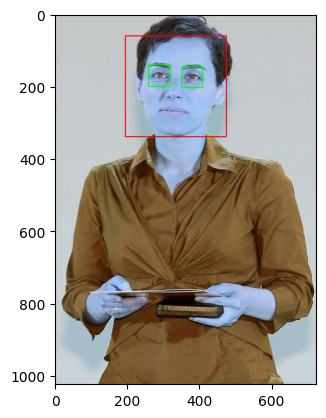

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray_img[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img)
plt.show()

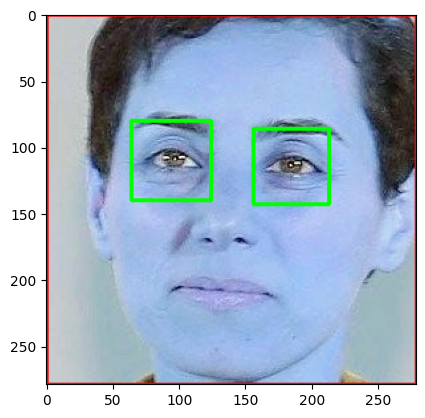

In [11]:
plt.imshow(roi_color, cmap='gray')

#### 3. Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face regionLet'ss write aPythonn function that can takean  input image andreturnsa  cropped image (if face and eyes >=2 are detected)

In [12]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error reading image: {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
    return None

(-0.5, 723.5, 1023.5, -0.5)

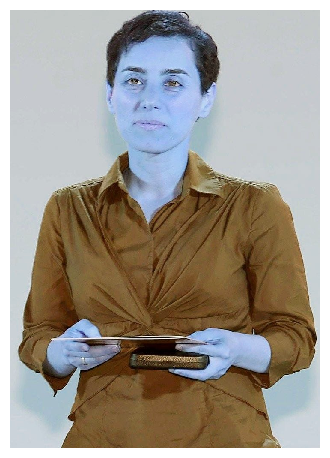

In [13]:
original_image = cv2.imread("./test_images/Maryam-Mirzakhani-1.jpg")
plt.matshow(original_image)
plt.axis('off')

(-0.5, 278.5, 278.5, -0.5)

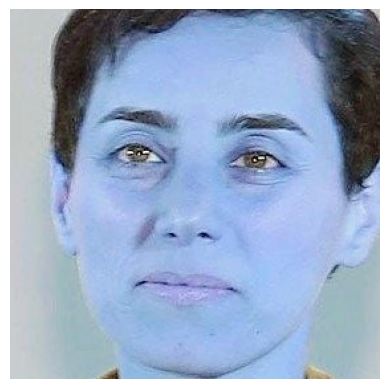

In [14]:
cropped_image = get_cropped_image_if_2_eyes("./test_images/Maryam-Mirzakhani-1.jpg")
plt.imshow(cropped_image)
plt.axis('off')

#### In the image below face is not very clear and it doesn't have two eyes clearly visible.

(-0.5, 1073.5, 603.5, -0.5)

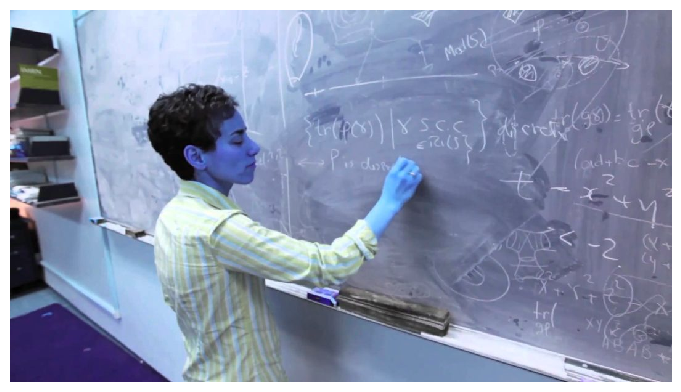

In [15]:
"test_images/maryam-mirzakhani.jpg"
org_image_obstructed = cv2.imread("./test_images/maryam-mirzakhani.jpg")
plt.matshow(org_image_obstructed)
plt.axis('off')

In [16]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes("./test_images/maryam-mirzakhani.jpg")
cropped_image_no_2_eyes

#### According to the image above, since the eyes are not detectable there is no cropped image as an output. Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training

In [17]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

#### Going through all images in the dataset folder and create cropped images for them. There will be a cropped folder inside the dataset folder after you run this code

In [18]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [19]:
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [20]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

elon musk
Generating cropped images in folder:  ./dataset/cropped/elon musk
jeff bezos
Generating cropped images in folder:  ./dataset/cropped/jeff bezos
mark zuckerberg
Generating cropped images in folder:  ./dataset/cropped/mark zuckerberg
maryam mirzakhani
Generating cropped images in folder:  ./dataset/cropped/maryam mirzakhani
tim cook
Generating cropped images in folder:  ./dataset/cropped/tim cook
warren buffett
Generating cropped images in folder:  ./dataset/cropped/warren buffett



#### Some cropped image samples are shown below with their respective classes.

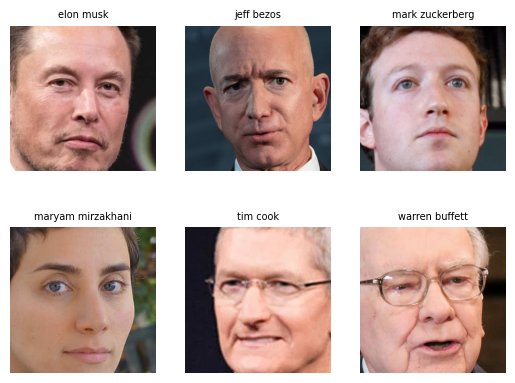

In [21]:
cropped_images_test = ['dataset/cropped/elon musk/elon musk1.png', 
                       'dataset/cropped/jeff bezos/jeff bezos13.png',
                       'dataset/cropped/mark zuckerberg/mark zuckerberg1.png',
                       'dataset/cropped/maryam mirzakhani/maryam mirzakhani12.png',
                       'dataset/cropped/tim cook/tim cook1.png',
                       'dataset/cropped/warren buffett/warren buffett2.png']


celeb_names = [img_dir.split('/')[-2] for img_dir in cropped_images_test]
for i, path in enumerate(cropped_images_test):
    cropped_img = cv2.imread(path)
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)  
    plt.subplot(2, 3, i+1)  
    plt.imshow(cropped_img)
    plt.title(celeb_names[i], fontsize = 7)
    plt.axis('off')

#### 4. Preprocessing: Use wavelet transform as a feature for training our model
In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc
Wavelet transform

In [22]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

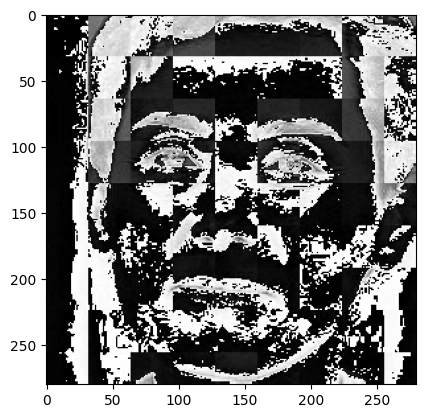

In [23]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [24]:
celebrity_file_names_dict

{'elon musk': ['./dataset/cropped/elon musk/elon musk1.png',
  './dataset/cropped/elon musk/elon musk2.png',
  './dataset/cropped/elon musk/elon musk3.png',
  './dataset/cropped/elon musk/elon musk4.png',
  './dataset/cropped/elon musk/elon musk5.png',
  './dataset/cropped/elon musk/elon musk6.png',
  './dataset/cropped/elon musk/elon musk7.png',
  './dataset/cropped/elon musk/elon musk8.png',
  './dataset/cropped/elon musk/elon musk9.png',
  './dataset/cropped/elon musk/elon musk10.png',
  './dataset/cropped/elon musk/elon musk11.png',
  './dataset/cropped/elon musk/elon musk12.png',
  './dataset/cropped/elon musk/elon musk13.png',
  './dataset/cropped/elon musk/elon musk14.png',
  './dataset/cropped/elon musk/elon musk15.png',
  './dataset/cropped/elon musk/elon musk16.png',
  './dataset/cropped/elon musk/elon musk17.png',
  './dataset/cropped/elon musk/elon musk18.png',
  './dataset/cropped/elon musk/elon musk19.png',
  './dataset/cropped/elon musk/elon musk20.png',
  './dataset/cro

In [25]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'elon musk': 0,
 'jeff bezos': 1,
 'mark zuckerberg': 2,
 'maryam mirzakhani': 3,
 'tim cook': 4,
 'warren buffett': 5}

#### 5.Preprocessing: perform data augmentation by performing rotation and flipping to add diversity to our model.

In [26]:
def augment_image(image):
    rows, cols, _ = image.shape
    # Rotation
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 10, 1)
    rotated = cv2.warpAffine(image, M, (cols, rows))
    # Flipping
    flipped = cv2.flip(image, 1)
    return [rotated, flipped]

#### Images in the cropped folder can be used for model training. We will use these raw images along with wavelet-transformed images to train our classifier. Let's prepare X and y now.

In [27]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is not None:
            # Original image
            scalled_raw_img = cv2.resize(img, (32, 32))
            img_har = w2d(img, 'db1', 5)
            scalled_img_har = cv2.resize(img_har, (32, 32))
            combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32, 1)))
            X.append(combined_img)
            y.append(class_dict[celebrity_name])
            
            # Augmented images
            for augmented_img in augment_image(img):
                scalled_raw_img = cv2.resize(augmented_img, (32, 32))
                img_har = w2d(augmented_img, 'db1', 5)
                scalled_img_har = cv2.resize(img_har, (32, 32))
                combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32, 1)))
                X.append(combined_img)
                y.append(class_dict[celebrity_name])

In [28]:
len(X[0])

4096

In [29]:
32*32*3 + 32*32

4096

In [30]:
X[0]

array([[ 67],
       [ 74],
       [ 93],
       ...,
       [241],
       [ 14],
       [ 62]], dtype=uint8)

In [31]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(408, 4096)

In [32]:
X[0]

array([ 67.,  74.,  93., ..., 241.,  14.,  62.])

In [33]:
X = np.array(X).reshape(len(X), -1)
y = np.array(y)

#### The data cleaning process is done. Now let's train the model.Thee SVM withrbff kernel tuned with heuristic finetunin is used.g

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X, y)
pipe.score(X_test, y_test)

1.0

In [35]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        12

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102



#### Let's use GridSearch to try out different models with different parameters. The goal is to come up with the best model with best fine-tuned parameters

In [36]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [37]:
import pandas as pd
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it w

,model,best_score,best_params
0,svm,0.836436,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.559281,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.839714,{'logisticregression__C': 1}


In [38]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [39]:
best_estimators['svm'].score(X_test,y_test)

0.9019607843137255

In [40]:
best_estimators['random_forest'].score(X_test,y_test)

0.6078431372549019

In [41]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8921568627450981

#### SVM could preform a better prediction. we will use this model for further developments and HTML creation.

In [42]:
from sklearn.metrics import confusion_matrix
best_clf = best_estimators['svm']
ypred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cm

array([[25,  0,  2,  0,  0,  0],
       [ 0, 12,  2,  0,  0,  0],
       [ 0,  1,  9,  2,  0,  0],
       [ 0,  0,  0, 25,  0,  0],
       [ 0,  1,  0,  0, 10,  1],
       [ 0,  0,  0,  1,  0, 11]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

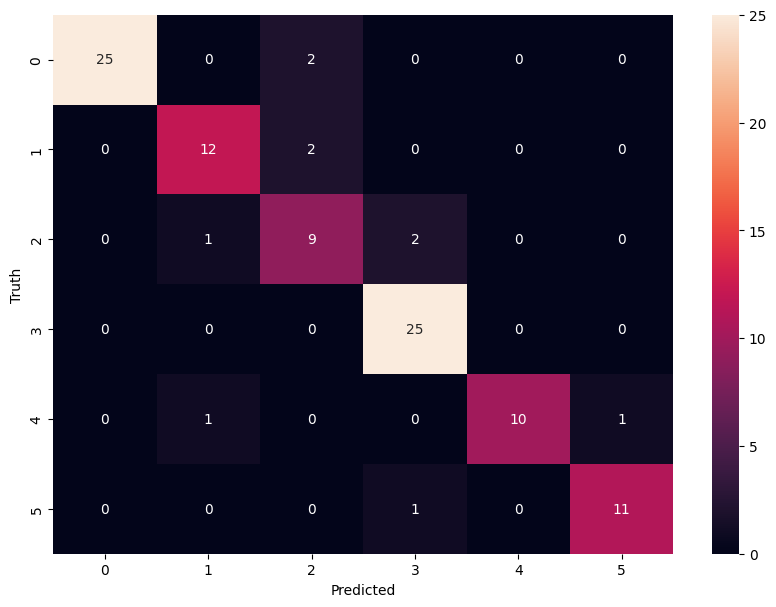

In [43]:
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Now let's check in which cases the predicted model contradicts the ground truth. For example, the true label of the 21st case was Mark Zuckerberg but the model predicted it as Maryam Mirzakhani.

In [44]:
np.where(y_test != ypred)

(array([ 13,  20,  24,  30,  49,  56,  57,  84,  85, 101], dtype=int64),)

In [45]:
print("{}".format(celeb_names[y_test[49]]))

mark zuckerberg


In [46]:
print("{}".format(celeb_names[ypred[49]]))

maryam mirzakhani


(-0.5, 31.5, 31.5, -0.5)

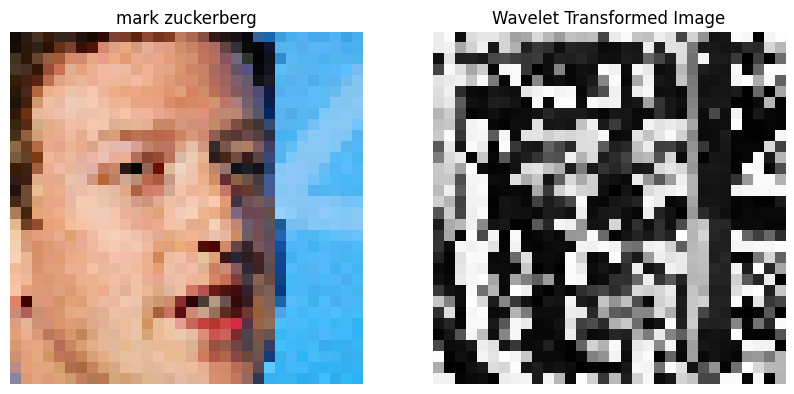

In [47]:
original_image_data = X_test[49][:32 * 32 * 3]
original_image = np.clip(original_image_data, 0, 255).astype(np.uint8).reshape(32, 32, 3)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

transformed_image_data = X_test[49][32 * 32 * 3:]
transformed_image = np.clip(transformed_image_data, 0, 255).astype(np.uint8).reshape(32, 32)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("{}".format(celeb_names[y_test[49]]))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image, cmap='gray')
plt.title("Wavelet Transformed Image")
plt.axis('off')

In [48]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [49]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))